In [1]:
import torch
import torch.nn as nn
#from pyhessian import hessian
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from torchsummary import summary
import scipy as sp
from jax import random
from neural_tangents import stax
import neural_tangents as nt
import jax.numpy as jnp

epochs = 3000
n_tasks = 1
L = 0
gamma0 = 1
widths = [4096 for _ in range(10)]
device = 'cuda'
gen = torch.Generator(device=device)
torch.cuda.manual_seed(1234)
batch = 25

class MLP(nn.Module):
            def __init__(self, w, L, param, gam):
                super(MLP, self).__init__()
                self.w = w
                if param =='ntk':
                    self.gamma = gam
                    self.in_scale = 784**0.5
                    self.out_scale = self.w**0.5*self.gamma
                elif param == 'mup': 
                     self.gamma = gam*self.w**0.5
                     self.in_scale = 784**0.5
                     self.out_scale = self.w**0.5*self.gamma
                elif param == 'sp':
                     self.gamma = 1
                     self.in_scale = 1
                     self.out_scale = 1

                self.fc1 = nn.Linear(784, self.w, bias=False)
                self.fc2 = nn.Linear(self.w, 1, bias=False)
                self.relu = nn.ReLU()
                self.L = L

            def forward(self, x):
                h1 = self.fc1(x)/self.in_scale
                h1act = self.relu(h1)
                h2 = self.fc2(h1act)/self.out_scale

                return h2
            
@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.normal_()
        
def permut_row(x, perm):
            return x[perm]

        # ---------------------- START DATA -------------------------
data = pd.read_csv('mnist_train.csv')
test = pd.read_csv('mnist_test.csv')
data = data[data['label'].isin([0, 1])]
test = test[test['label'].isin([0, 1])]
X = torch.tensor(data.drop('label', axis = 1).to_numpy(), device=device)/255
X_test = torch.tensor(test.drop('label', axis = 1).to_numpy(), device=device)/255
X = X[:batch]

Y_temp = torch.tensor(data['label'].to_numpy(), device=device)
Y = torch.tensor([[y*1.0] for y in Y_temp], device=device)
Y = Y[:batch]
_ , indeces = torch.sort(Y_temp[:batch])
Y = Y[indeces]
X = X[indeces]

Y_temp = torch.tensor(test['label'].to_numpy(), device=device)
Y_test = torch.tensor([[y*1.0] for y in Y_temp], device=device)

tasks = [X]
tasks_test = [X_test]

for _ in range(n_tasks):
        perm = np.random.permutation(X.shape[1])
        tasks.append( torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X.cpu(), perm=perm)).to(device) )
        tasks_test.append(torch.tensor(np.apply_along_axis(permut_row, axis = 1, arr=X_test.cpu(), perm=perm)).to(device))

def compute_NTK(model,X1,X2):

    layers = [p.data.to(device) for p in model.parameters()]
    act_der1 = (X1 @ layers[0].T > 0)*1.0
    act1 = (X1 @ layers[0].T) * act_der1
    act_der2 = (X2 @ layers[0].T > 0)*1.0
    act2 = (X2 @ layers[0].T) * act_der2

    ntkemp = 1/(N*784)*( (act_der1 @ layers[1].T) @ (act_der2 @ layers[1].T).T * (X1 @ X2.T) + act1@act2.T)
    return ntkemp

2024-08-29 15:22:32.376536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 15:22:32.394138: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 15:22:32.399531: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 15:22:33.264168: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
save_out = False

res1 = np.zeros((epochs*2,len(X)))
res2 = np.zeros((epochs*2,len(X)))

for regime in ['ntk']:
    for N in widths:

        loss_hist = []
        lam = []
        acc = []
        all = []
        res1t = []
        res2t = []
        norm = []
        
        mlp = MLP(N,L,regime, gamma0)

        ntk11emp = compute_NTK(mlp,tasks[0],tasks[0])
        ntk12emp = compute_NTK(mlp,tasks[0],tasks[1])
        ntk22emp = compute_NTK(mlp,tasks[1],tasks[1])
        
        lrs = {'sp':1,'ntk':0.1,'mup': mlp.gamma**2}
        lr = lrs.get(regime)

        if regime == 'ntk' or regime == 'mup':
            mlp = mlp.apply(init_weights)
            
        #summary(mlp, (1,784))
        mlp = mlp.to(device)
        
        optimizer = torch.optim.SGD(mlp.parameters(), lr= lr )
        eos = 2/lr
     
        MSE = nn.MSELoss()

        for t,Xt in enumerate(tasks):        
                for epoch in range(epochs):

                        running_loss = 0.0
                        for i in range(len(Xt)//batch):

                            # Batch of training 
                            ix = torch.randint(0, len(X), (batch,), generator=gen, device=device)

                            #ixc = torch.randint(0, len(X), (1024,), generator=gen, device=device)

                            #lt = []
                            #for s in range(t+1):
                            #    sharp, eigen = top_eigen(mlp, MSE, tasks[s][ixc], Y[ixc])
                            #    lt.append(sharp)
                            #lam.append(lt)    

                            optimizer.zero_grad()

                            out = mlp(Xt[ix])
                            loss = MSE(out, Y[ix])*0.5

                            res1t.append( list((torch.sum(mlp(tasks[0][ix]) - Y[ix], dim=1)).detach().cpu()) )
                            res2t.append( list((torch.sum(mlp(tasks[1][ix]) - Y[ix], dim=1)).detach().cpu()) )
                            
                            loss.backward()
                            running_loss += loss.item()

                            #over, no = overlap(mlp, X[ix], Y[ix])

                            #all.append(over)
                            #norm.append(no)
                            
                            optimizer.step()
                            loss_hist.append(loss.item())

                            #print(f'task {t} : (epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss = {loss.item():.4f}')

                print(f'Finished Training task{t}, train loss: {running_loss/batch}')
                
                acct = []
                for s in range(t+1):
                    acct.append( (torch.sum(torch.argmax(mlp(tasks_test[s]), dim=1) == torch.argmax(Y_test, dim=1))/len(Y_test)).item() )  
                acc.append(acct) 
        
        res1 += np.array(res1t)/len(widths)
        res2 += np.array(res2t)/len(widths)

        if save_out:        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/lamda{N}_{regime}.txt', 'w') as file:
            
                for lst in lam:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/acc{N}_{regime}.txt', 'w') as file:

                for lst in acc:
                    file.write(' '.join(map(str, lst)) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/overlap{N}_{regime}.txt', 'w') as file:

                for a in all:
                    file.write(str(a) + ' ')
        
            with open(f'/Users/alessandrobreccia/Desktop/THESIS/data/norm{N}_{regime}.txt', 'w') as file:

                for n in norm:
                    file.write(str(n) + ' ')

Finished Training task0, train loss: 0.00019084777683019637
Finished Training task1, train loss: 0.00039457522332668303
Finished Training task0, train loss: 0.0004583699628710747
Finished Training task1, train loss: 0.0002858729846775532
Finished Training task0, train loss: 0.00034588992595672606
Finished Training task1, train loss: 8.720354177057743e-05
Finished Training task0, train loss: 0.00016745643690228463
Finished Training task1, train loss: 0.00036683328449726104
Finished Training task0, train loss: 0.00028271496295928956
Finished Training task1, train loss: 0.00016477908939123155
Finished Training task0, train loss: 0.00019421439617872238
Finished Training task1, train loss: 0.00026853032410144805
Finished Training task0, train loss: 0.00023155922070145608
Finished Training task1, train loss: 0.00023575188592076302
Finished Training task0, train loss: 0.00015210374258458614
Finished Training task1, train loss: 0.00019291337579488755
Finished Training task0, train loss: 0.0002

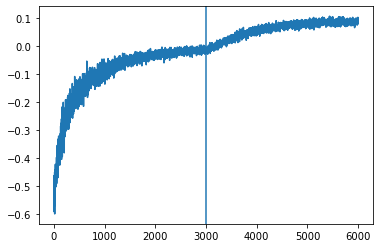

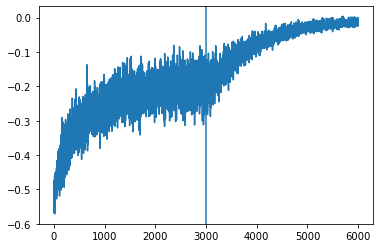

In [3]:
a = np.array(res1, dtype=float)
b = np.array(res2, dtype=float)

plt.plot(np.mean(a, axis=1))
plt.axvline(epochs)
plt.show()

plt.plot(np.mean(b, axis=1))
plt.axvline(epochs)
plt.show()

In [4]:
init_fn, apply_fn, _ = stax.serial(
    stax.Dense(widths[0]), stax.Relu(),
    stax.Dense(1),
)

key1, key2 = random.split(random.PRNGKey(1))

_, params = init_fn(key1, input_shape=X.shape)

kernel11 = nt.empirical_ntk_fn(apply_fn)
kernel22 = nt.empirical_ntk_fn(apply_fn)
kernel21 = nt.empirical_ntk_fn(apply_fn)
kernel12 = nt.empirical_ntk_fn(apply_fn)

ntk11tg = kernel11(jnp.array(tasks[0].cpu()), None, params)
ntk22tg = kernel22(jnp.array(tasks[1].cpu()), None, params)
ntk21tg = kernel21(jnp.array(tasks[1].cpu()), jnp.array(tasks[0].cpu()), params)
ntk12tg = kernel12(jnp.array(tasks[0].cpu()), jnp.array(tasks[1].cpu()), params)

ntk11tg = torch.tensor(np.array(ntk11tg)).to(device)
ntk22tg = torch.tensor(np.array(ntk22tg)).to(device)
ntk21tg = torch.tensor(np.array(ntk21tg)).to(device)
ntk12tg = torch.tensor(np.array(ntk12tg)).to(device)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
A, _ = torch.linalg.eig(ntk11tg)

In [6]:
2/(torch.max(torch.view_as_real(A))+torch.min(torch.view_as_real(A)))

tensor(1.3686, device='cuda:0')

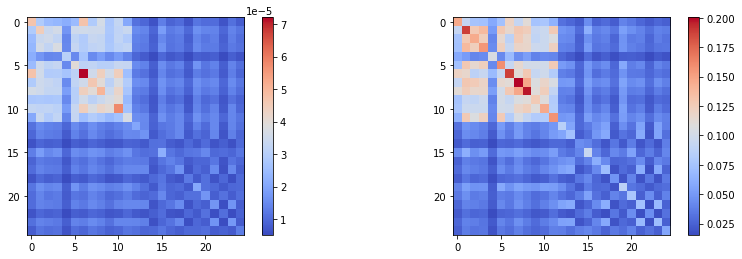

In [7]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
ax0 = ax[0].imshow(ntk11emp.cpu(), cmap='coolwarm')
plt.colorbar(ax0, ax=ax[0])

ax1 = ax[1].imshow(ntk11tg.cpu(), cmap='coolwarm')
plt.colorbar(ax1, ax=ax[1])
plt.show()

In [8]:
def delta2(t,delta10, delta20, ntk, ntk_mix,):
    ntk = torch.tensor(ntk).to('cpu')

    term_time = lr/gamma0*torch.tensor(delta10, dtype=torch.float32).to(device) @ torch.matrix_exp(-lr/gamma0*ntk).to(device)

    d =  torch.tensor(delta20, dtype=torch.float32).to(device) - ntk_mix @ term_time

    return d.cpu()

def delta1( delta0, ntk):

    ntk = torch.tensor(ntk).to(device)

    term_time = lr/gamma0 * ntk @ torch.tensor(delta0, dtype=torch.float32).to(device)

    d = torch.tensor(delta0, dtype=torch.float32).to(device) - term_time

    return np.array(d.cpu())


d1 = np.array(torch.sum(Y, dim=1).cpu()*-1)
d2 = np.array(torch.sum(Y, dim=1).cpu()*-1)
d3 = np.array([])
d4 = np.array([])

for t in range(epochs):
    d1 = np.append(d1,delta1(d1[-batch:], ntk11tg/batch) ) 
    d2 = np.append(d2,delta2(t, d1[-batch:], d2[-batch:], ntk11tg/batch, ntk12tg.T/batch))

d3 = np.array(d2[-batch:])
d4 = np.array(d1[-batch:])
for t in range(epochs): 
    d3 = np.append(d3,delta1(d3[-batch:], ntk22tg/batch) ) 
    d4 = np.append(d4,delta2(t, d3[-batch:], d4[-batch:], ntk22tg/batch, ntk12tg/batch))
    

/tmp/ipykernel_59218/2540620102.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ntk = torch.tensor(ntk).to(device)
/tmp/ipykernel_59218/2540620102.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ntk = torch.tensor(ntk).to('cpu')


In [9]:
delta1fin = torch.mean(torch.tensor(d2[:batch]) - ntk12tg.T.cpu() @ torch.linalg.inv(ntk11tg.cpu()) @ d1[:batch])

In [10]:
delta2fin = torch.mean(torch.tensor(d1[epochs*batch:epochs*batch+batch]) - ntk12tg.cpu() @ torch.linalg.inv(ntk22tg.cpu()) @ d2[epochs*batch:epochs*batch+batch])

In [11]:
x1 = d1.reshape(epochs+1,batch)
x2 = d2.reshape(epochs+1,batch)
x3 = d3.reshape(epochs+1,batch)
x4 = d4.reshape(epochs+1,batch)

time2 = np.linspace(0,epochs,int(epochs/10))
time = np.linspace(0,epochs,epochs+1)
time2task = np.linspace(epochs,2*epochs,epochs+1)
time2t = np.linspace(epochs,2*epochs,int(epochs/10))

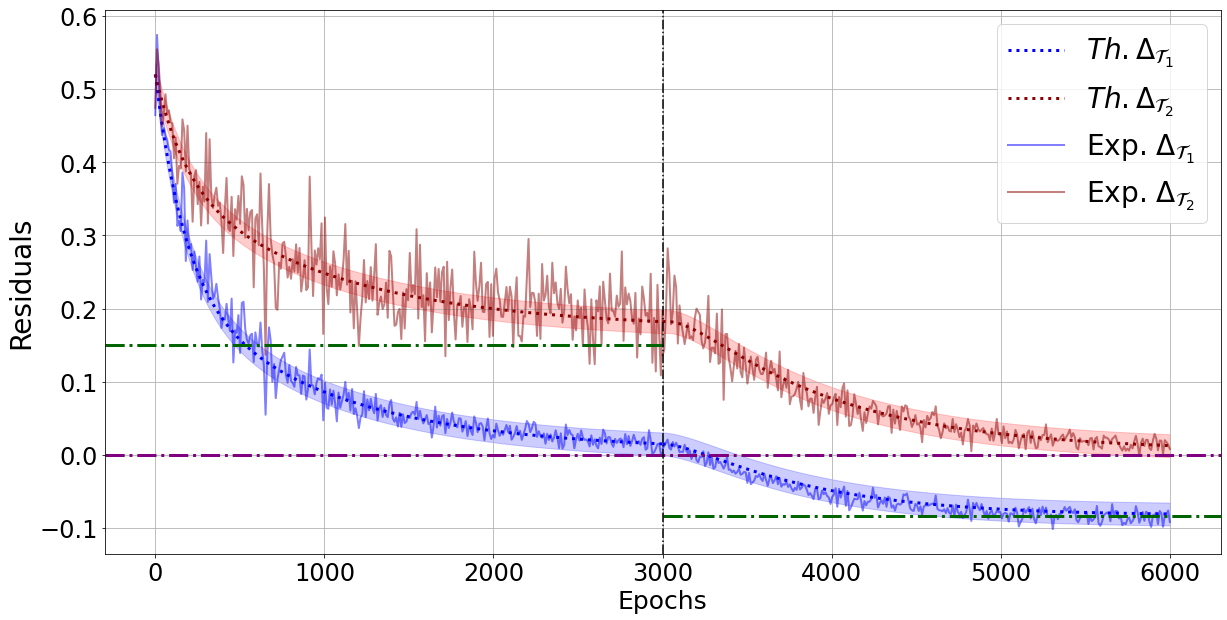

In [28]:
fig = plt.figure(figsize=(20,10))
#plt.title('Residuals evolution of both tasks')

plt.plot(time,-np.mean(x1,axis=1) , label='$Th. \Delta_{\mathcal{T}_1}$', color='blue', linestyle=':', linewidth=3,)
plt.fill_between(time, -np.mean(x1,axis=1) - 1/np.sqrt(N), -np.mean(x1,axis=1) + 1/np.sqrt(N), alpha=0.2, color='blue')

plt.plot(time,-np.mean(x2,axis=1) , label='$Th. \Delta_{\mathcal{T}_2}$',color='darkred', linestyle=':',linewidth=3, )
plt.fill_between(time, -np.mean(x2,axis=1) - 1/np.sqrt(N), -np.mean(x2,axis=1) + 1/np.sqrt(N), alpha=0.2, color='red')

plt.plot(time2task,-np.mean(x3,axis=1) , color='darkred', linestyle=':', linewidth=3, )
plt.fill_between(time2task, -np.mean(x3,axis=1) - 1/np.sqrt(N), -np.mean(x3,axis=1) + 1/np.sqrt(N), alpha=0.2, color='red')

plt.plot(time2task,-np.mean(x4,axis=1) , color='blue', linestyle=':', linewidth=3,)
plt.fill_between(time2task, -np.mean(x4,axis=1) - 1/np.sqrt(N), -np.mean(x4,axis=1) + 1/np.sqrt(N), alpha=0.2, color='blue')


plt.plot(time2,-np.mean(a[:epochs:10], axis=1) , label='Exp. $\Delta_{\mathcal{T}_1}$', alpha=0.5, color='blue', linewidth=2)
plt.plot(time2, -np.mean(b[:epochs:10], axis=1), label = 'Exp. $\Delta_{\mathcal{T}_2}$', alpha=0.5, color='darkred',linewidth=2)
plt.plot(time2t,-np.mean(b[epochs::10], axis=1), alpha=0.5, color='darkred',linewidth=2)
plt.plot(time2t, -np.mean(a[epochs::10], axis=1), alpha=0.5, color='blue',linewidth=2)

plt.axhline(0, color='purple', linestyle='-.', linewidth=3)
plt.axhline(-delta1fin, xmin=0, xmax=0.5, color='darkgreen', linestyle='-.', linewidth=3)
plt.axhline(-delta2fin, xmin=0.5, xmax=1, color='darkgreen', linestyle='-.', linewidth=3)

plt.axvline(epochs, color='black', linestyle='-.')
plt.xlabel('Epochs', fontsize=25)
plt.ylabel('Residuals', fontsize=28)
plt.grid()
plt.xticks(size=24)
plt.yticks(size=24)
plt.legend(prop={'size': 28})
plt.show()

